In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
! pip install -q pyspark==3.3.0 spark-nlp==4.2.8
!pip install wordcloud

In [66]:
import sparknlp
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, rtrim
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, to_timestamp
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from wordcloud import WordCloud
from pyspark.ml.feature import Tokenizer

In [67]:
spark = sparknlp.start()
print ("Spark NLP Version :", sparknlp.version())
spark

Spark NLP Version : 4.2.8


In [92]:
df = spark.read.parquet('/content/drive/MyDrive/Machine Learning/Bigdata/final_project/trump_biden_sentiment.parquet')

In [93]:
df.show(10)

+-------------------+--------------------+--------------------+-----+-------------+-------------------+--------------------+--------------------+----------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+-------------+--------------------+-------------+-----------+----------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+---------+
|         created_at|            tweet_id|               tweet|likes|retweet_count|             source|             user_id|           user_name|user_screen_name|    user_description|     user_join_date|user_followers_count|     user_location|               lat|              long|         city|             country|    continent|      state|state_code|        collected_at|   candidate|            document| sentence_embeddings|            language|      sentiment_view|          cols|lan

In [94]:
#user activity
active_users = df.groupBy("user_name").count().orderBy(col("count").desc())
active_users.show(truncate=False)

+-------------------------------------+-----+
|user_name                            |count|
+-------------------------------------+-----+
|VOTE BLUE Steve Ziegenbusch👑        |2207 |
|THCPetDoctor                         |2021 |
|Presidential News Network            |1893 |
|Maureen Devlin                       |1584 |
|Mr Just Sayin'                       |1533 |
|Adam Roosevelt                       |1403 |
|joshua epstein🏳️‍🌈🖖🏼🗽👨🏼‍💻🇺🇸|1401 |
|RodRaphael                           |1324 |
|John Michaels                        |1230 |
|Andy Ostroy                          |1120 |
|anita.beavers                        |1119 |
|🕎Vet Eric Man🕎                     |896  |
|Michael Chapman                      |891  |
|Doody Giuliani                       |848  |
|(((Alan Tonelson)))                  |845  |
|Arcane Treasures                     |834  |
|Kate J Chase                         |820  |
|Liz Eisen                            |803  |
|mclozano1111                         |715  |
|

In [95]:
active_users_pd = active_users.toPandas()

In [96]:
# Replace 'null' with 'Unknown'
active_users_pd['user_name'] = active_users_pd['user_name'].fillna('Unknown')

<ipython-input-97-192a0265da0a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='user_name', y='count', data=active_users_pd.head(10), palette='viridis')
<ipython-input-97-192a0265da0a>:26: UserWarning: Glyph 128081 (\N{CROWN}) missing from current font.
  plt.tight_layout()
<ipython-input-97-192a0265da0a>:26: UserWarning: Glyph 127987 (\N{WAVING WHITE FLAG}) missing from current font.
  plt.tight_layout()
<ipython-input-97-192a0265da0a>:26: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  plt.tight_layout()
<ipython-input-97-192a0265da0a>:26: UserWarning: Glyph 128406 (\N{RAISED HAND WITH PART BETWEEN MIDDLE AND RING FINGERS}) missing from current font.
  plt.tight_layout()
<ipython-input-97-192a0265da0a>:26: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from current font.
  plt.ti

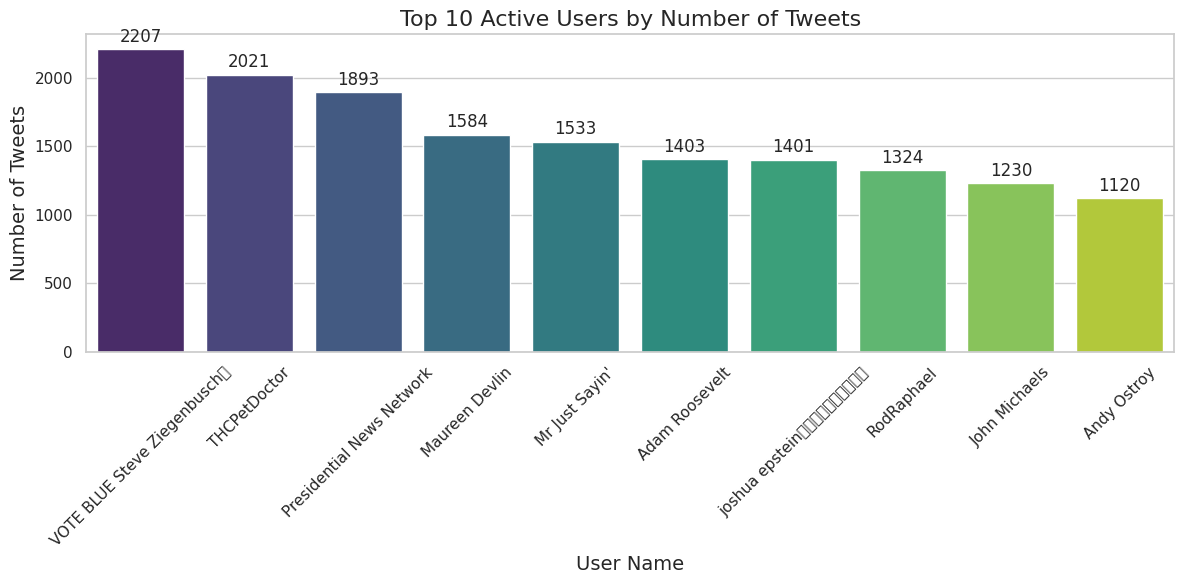

In [97]:
sns.set(style="whitegrid")

#Create a graphics object and set the graphics size
plt.figure(figsize=(12, 6))

# Use Seaborn's barplot to create a bar chart, which can be drawn directly from the DataFrame and automatically beautified.
ax = sns.barplot(x='user_name', y='count', data=active_users_pd.head(10), palette='viridis')

# Set chart title and axis labels
ax.set_title('Top 10 Active Users by Number of Tweets', fontsize=16)
ax.set_xlabel('User Name', fontsize=14)
ax.set_ylabel('Number of Tweets', fontsize=14)

# Add numerical labels to each bar of the bar chart
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  # Format tags as integers
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Use tight_layout to automatically adjust the subgraph parameters to ensure that the elements of the entire chart are displayed correctly without overlapping parts.
plt.tight_layout()

plt.show()

In [98]:
# Tweet source distribution
source_distribution = df.groupBy("source").count().orderBy(col("count").desc())
filtered_source_distribution = source_distribution.filter(~col("source").rlike("^-?[0-9\.]+$"))


In [99]:
filtered_source_distribution.show()

+--------------------+------+
|              source| count|
+--------------------+------+
|  Twitter for iPhone|224710|
|     Twitter Web App|118450|
| Twitter for Android| 61526|
|    Twitter for iPad| 22105|
|           Instagram|  4552|
|           TweetDeck|  3277|
|             dlvr.it|  2037|
|          NewsBot247|  1893|
|      Hootsuite Inc.|  1848|
|              Buffer|  1585|
|In-House App for ...|  1403|
|     Buffered Tweets|   834|
|       WordPress.com|   581|
|TweetCaster for A...|   554|
|           Periscope|   505|
|            Spreaker|   433|
| Jenkers Eng Posting|   404|
|               IFTTT|   403|
|     Twitter for Mac|   396|
|             Echofon|   353|
+--------------------+------+
only showing top 20 rows



In [100]:
source_distribution_pd = filtered_source_distribution.toPandas()

<ipython-input-101-f2f5a5acf7c0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='source', y='count', data=source_distribution_pd.head(10), palette='plasma')


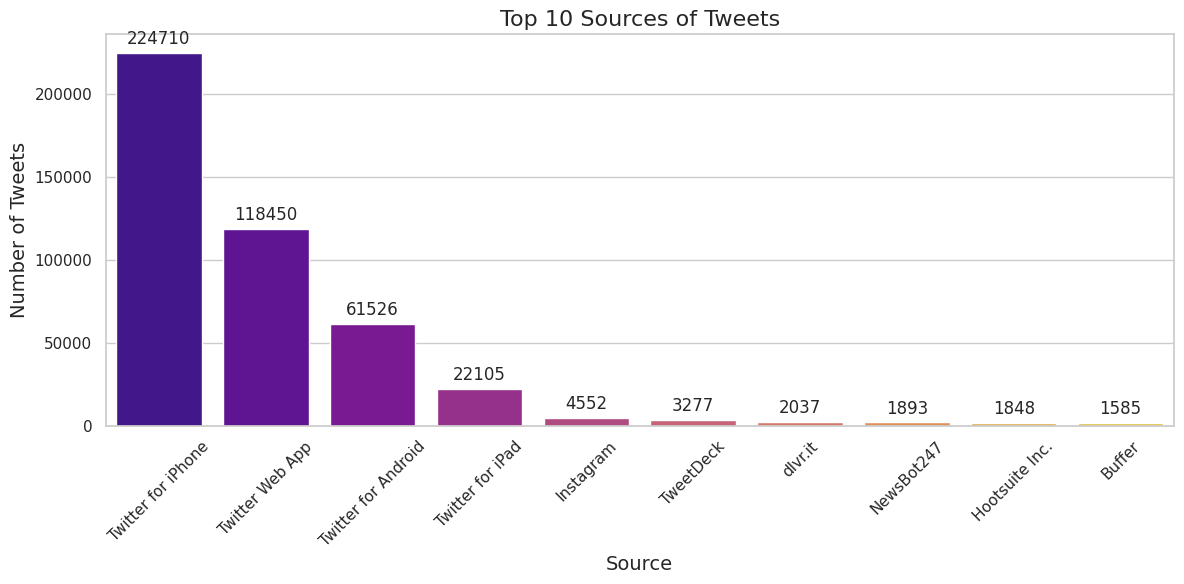

In [101]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

ax = sns.barplot(x='source', y='count', data=source_distribution_pd.head(10), palette='plasma')

ax.set_title('Top 10 Sources of Tweets', fontsize=16)
ax.set_xlabel('Source', fontsize=14)
ax.set_ylabel('Number of Tweets', fontsize=14)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  # Format labels using integers
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),  # Set the position offset of the text
                textcoords = 'offset points')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

In [109]:
# Geographical distribution analysis (taking countries as an example)
state_distribution = df.groupBy("state").count().orderBy(col("count").desc())
state_distribution.show()

+--------------------+-----+
|               state|count|
+--------------------+-----+
|          California|78182|
|            New York|56297|
|               Texas|42300|
|             Florida|36806|
|District of Columbia|21499|
|            Illinois|18287|
|        Pennsylvania|16206|
|                Ohio|12920|
|       Massachusetts|12756|
|          New Jersey|11870|
|      North Carolina| 9114|
|             Georgia| 8747|
|            Colorado| 8541|
|            Michigan| 7881|
|             Arizona| 7705|
|              Oregon| 6853|
|            Virginia| 6834|
|           Tennessee| 6584|
|            Maryland| 6275|
|            Missouri| 6254|
+--------------------+-----+
only showing top 20 rows



In [110]:
state_distribution_pd = state_distribution.toPandas()

In [111]:
state_distribution_pd['state'] = state_distribution_pd['state'].dropna() #romove NULL

<ipython-input-112-a3439b35d524>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='state', y='count', data=state_distribution_pd.head(10), palette='autumn')


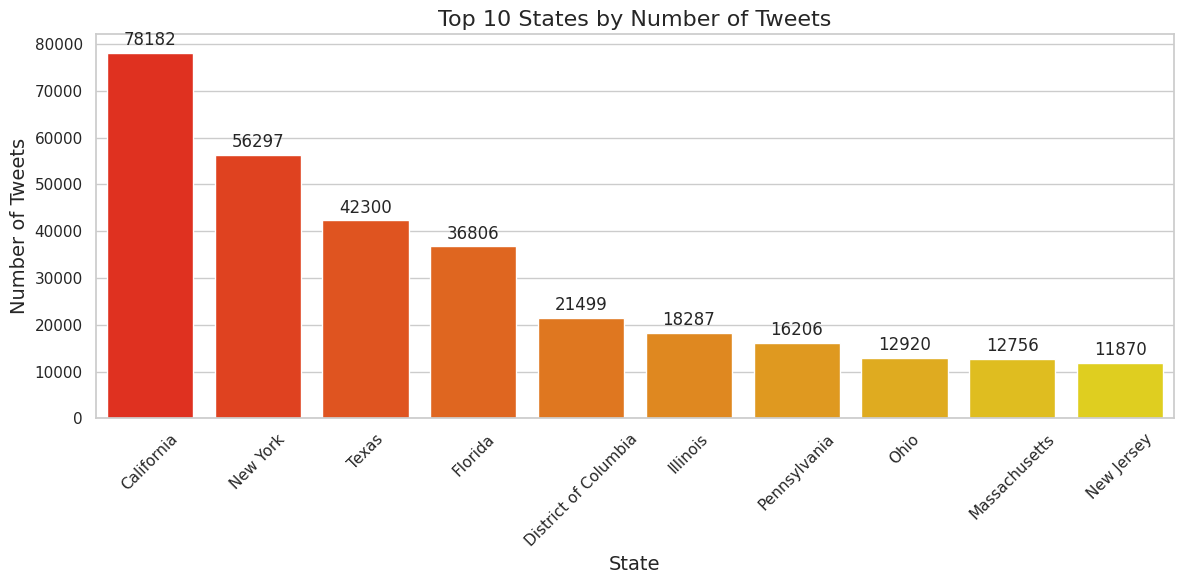

In [112]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

ax = sns.barplot(x='state', y='count', data=state_distribution_pd.head(10), palette='autumn')

ax.set_title('Top 10 States by Number of Tweets', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Number of Tweets', fontsize=14)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

<ipython-input-108-36d4ff09aa36>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='count', y='state', data=state_distribution_pd,


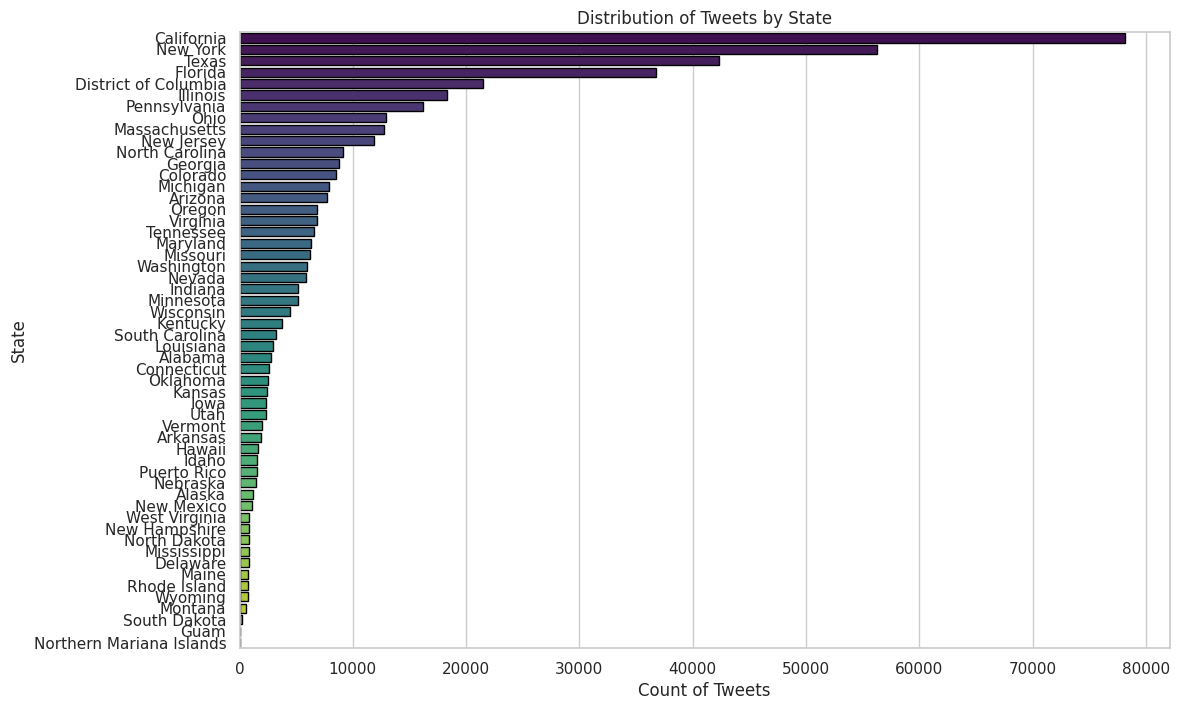

In [108]:
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='count', y='state', data=state_distribution_pd,
                       palette='viridis', edgecolor='black')

plt.title('Distribution of Tweets by State')
plt.xlabel('Count of Tweets')
plt.ylabel('State')

plt.show()

In [113]:
city_distribution = df.groupBy("city").count().orderBy(col("count").desc())
city_distribution_pd = city_distribution.toPandas()

<ipython-input-114-8d9f34ff06e2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='count', y='city', data=top_cities, palette='cool', edgecolor='black')


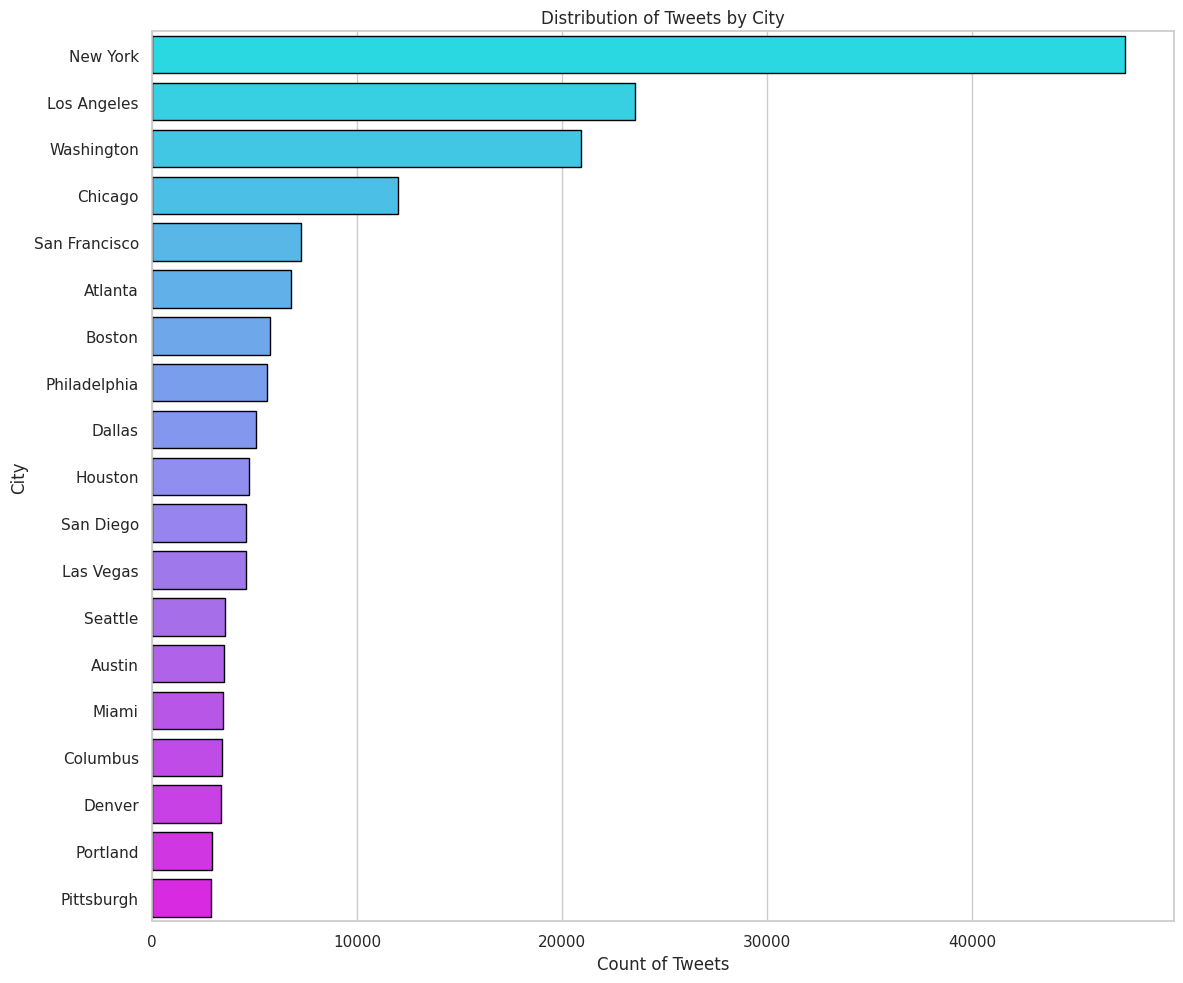

In [114]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 10))

top_cities = city_distribution_pd.head(20)
bar_plot = sns.barplot(x='count', y='city', data=top_cities, palette='cool', edgecolor='black')


plt.title('Distribution of Tweets by City')
plt.xlabel('Count of Tweets')
plt.ylabel('City')


plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


In [116]:
spark = SparkSession.builder \
    .appName("Tweet Analysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [117]:
df = df.withColumn("date", to_timestamp("created_at", 'yyyy-MM-dd HH:mm:ss'))

In [120]:
tweets_by_date = df.groupBy(col("date").cast("date")).count().orderBy(col("date").cast("date"))

In [121]:
tweets_by_date.show(10)

+------------------+-----+
|CAST(date AS DATE)|count|
+------------------+-----+
|              null| 3383|
|        2020-10-15|12274|
|        2020-10-16|18919|
|        2020-10-17|10541|
|        2020-10-18|10298|
|        2020-10-19|11405|
|        2020-10-20|11299|
|        2020-10-21|12660|
|        2020-10-22|14303|
|        2020-10-23|40642|
+------------------+-----+
only showing top 10 rows



In [122]:
tweets_by_date_pd = tweets_by_date.toPandas()
tweets_by_date_pd.rename(columns={"CAST(date AS DATE)": "date"}, inplace=True)

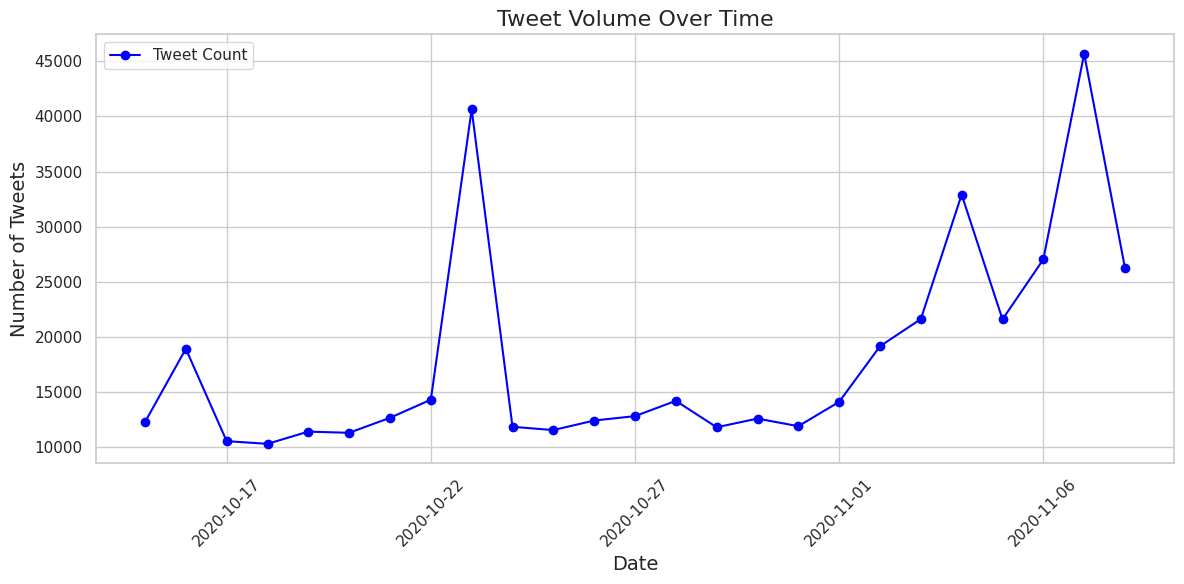

In [123]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

plt.plot(tweets_by_date_pd['date'], tweets_by_date_pd['count'], marker='o', linestyle='-', color='blue', label='Tweet Count')

plt.title('Tweet Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)

plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # 每5天显示一次日期

plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()